##   Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


## Get Data Labels

In [2]:
classes=[]
filename='input'
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)


['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


## Resize images and put together Training and Testing Datasets

In [3]:
X_train = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)): 
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)    

100%|█████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 119.87it/s]


## Data augmentation and splitting

In [4]:
#data augmentation
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7, #rotate images
    width_shift_range=0.05,
    height_shift_range=0.05, #shift image in horizontal and vertical
    zoom_range=0.1, #zoom images
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape
lb = LabelEncoder()

#train and test splitting 
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

## Load Transfer Model

In [5]:
#load EfficientNet
from tensorflow.keras.applications import EfficientNetV2B0

EfficientNet=EfficientNetV2B0(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

## Train the model

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#Currently I just load the model trained on imagenet and train the whole thing
#I should probably set learning rate an order of magnitude lower in the future
#(I just wanted this to run fast enough to test)

#Training things to do:
#Set lr to 0.0001

#1
#Rerun this model where we do transfer learning and train everything together immediately

#2
#Do the same but load the same model without any of the pretrained weights
#(change weights argument in previous cell)

#3
#Freeze the efficientnet model and train only the layers I added 

#4
#Freeze the efficientnet model and train only the layers I added
#But then unfreeze and use a much smaller (10 - 100x) lr to fine tune the whole thing

#See - https://keras.io/guides/transfer_learning

#Other things to do:
#Make nice looking plots illustrating performance throughout training for various models
#Probably confusion matrices or accuracy type stats for different models
#Plot some example images from the data set
#These are all done in naive and primitive forms below


tf.random.set_seed(45)

#define model structure
model = EfficientNet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model)
model = tf.keras.layers.Dropout(rate=0.33)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=EfficientNet.input, outputs = model)

#optimizer
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# summarize the model
#print(model.summary())

# early stopping due to lack of improvement
early_stopping_cb= EarlyStopping(patience=5,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001)

#train the model
history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=50,batch_size=32,callbacks=[early_stopping_cb, reduce_lr])

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.7197 - loss: 0.7489 - val_accuracy: 0.9061 - val_loss: 0.3509 - learning_rate: 0.0010
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9201 - loss: 0.2530 - val_accuracy: 0.9082 - val_loss: 0.2690 - learning_rate: 0.0010
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.9595 - loss: 0.1229 - val_accuracy: 0.9347 - val_loss: 0.2348 - learning_rate: 0.0010
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.9653 - loss: 0.1072 - val_accuracy: 0.9184 - val_loss: 0.2637 - learning_rate: 0.0010
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9717 - loss: 0.0869 - val_accuracy: 0.9429 - val_loss: 0.1872 - learning_rate: 0.0010
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9782 - loss: 0.0710 - val_accuracy: 0.9163 - val_loss: 0.2436 - learning_rate: 0.0010
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.9742 - loss: 0.0768 - val_acc

## Save Model & Plot Performance

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.9579 - loss: 0.1055
Accuracy: 96.938777


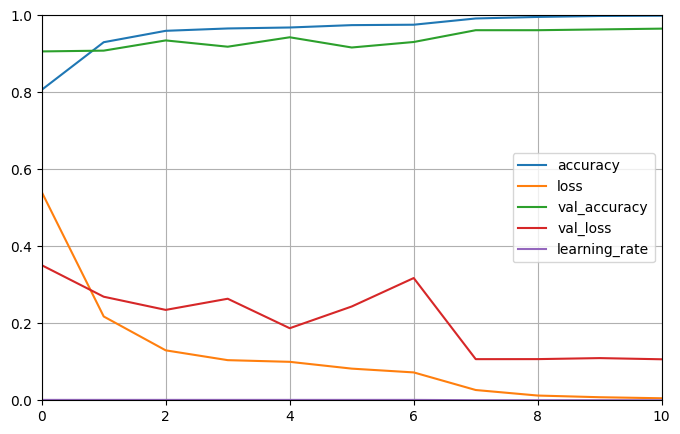

In [7]:
#save the model
model.save('models/EfficientNetV2B0.keras')
model.save_weights('models/EfficientNetV2B0.weights.h5')

#plot loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)

plt.gca().set_xlim(0,10)
plt.gca().set_ylim(0,1)
plt.savefig('plots/EfficientNetV2B0.png')
loss, accuracy = model.evaluate(X_test,y_test)

#print accuracy    
print('Accuracy: %f' % (accuracy*100))

In [8]:
#load the model
model=keras.models.load_model('models/EfficientNetV2B0.keras')  
loss, accuracy = model.evaluate(X_test,y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step - accuracy: 0.9579 - loss: 0.1055


## <font color='Aquamarine'>Accuracy and Loss</font> 

In [9]:
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 96.939 
 loss : 0.102


In [10]:

y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred) #predicted labels

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 546ms/step


In [11]:
pd.Series(pred_labels).value_counts()

meningioma_tumor    144
pituitary_tumor     138
glioma_tumor        134
no_tumor             74
Name: count, dtype: int64

## <font color='Aquamarine'>Confusion Matrix</font> 

Text(98.2222222222222, 0.5, 'Predicted class')

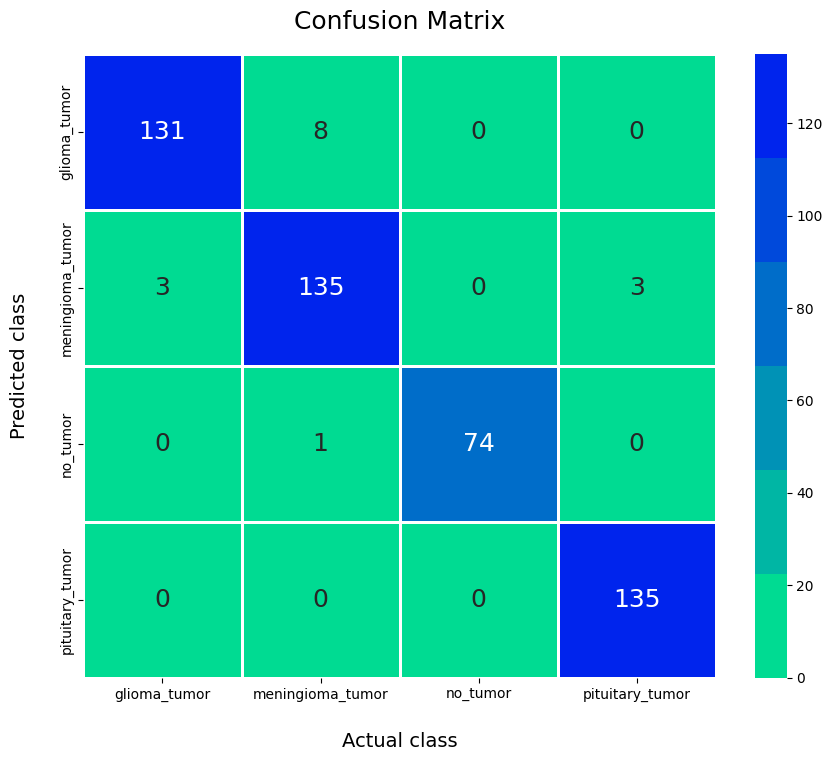

In [12]:
cm = confusion_matrix(y_test,pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r inverts the palette
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
 #annot_kws: settings about annotations
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)
#plt.savefig(os.path.join('plots/','EfficientNetB3_confusion_matrix.png'), dpi=300)

## <font color='Aquamarine'>Model performance scores</font> 

In [13]:
print(classification_report(y_test,pred,target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.98      0.94      0.96       139
meningioma_tumor       0.94      0.96      0.95       141
        no_tumor       1.00      0.99      0.99        75
 pituitary_tumor       0.98      1.00      0.99       135

        accuracy                           0.97       490
       macro avg       0.97      0.97      0.97       490
    weighted avg       0.97      0.97      0.97       490



In [14]:
import matplotlib.image as mpimg
TEST_DIR='input/Testing'
#fetch images from the original validation dataset and resize them in order to plot the images.
images=[] 
n_classes=4
z_max=20
for i,filenames in enumerate(os.listdir(TEST_DIR)): 
    dir_fold=os.path.join(TEST_DIR, filenames)
    print(dir_fold)
    class_images=[]
    z=0
    for filename in os.listdir(dir_fold):
        if z < z_max:
            img_path = os.path.join(dir_fold, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img,(image_size,image_size))
            class_images.append(img)
            z+=1
        else:
            break
    images.append(class_images)
images=images[:20]


input/Testing\glioma_tumor
input/Testing\meningioma_tumor
input/Testing\no_tumor
input/Testing\pituitary_tumor


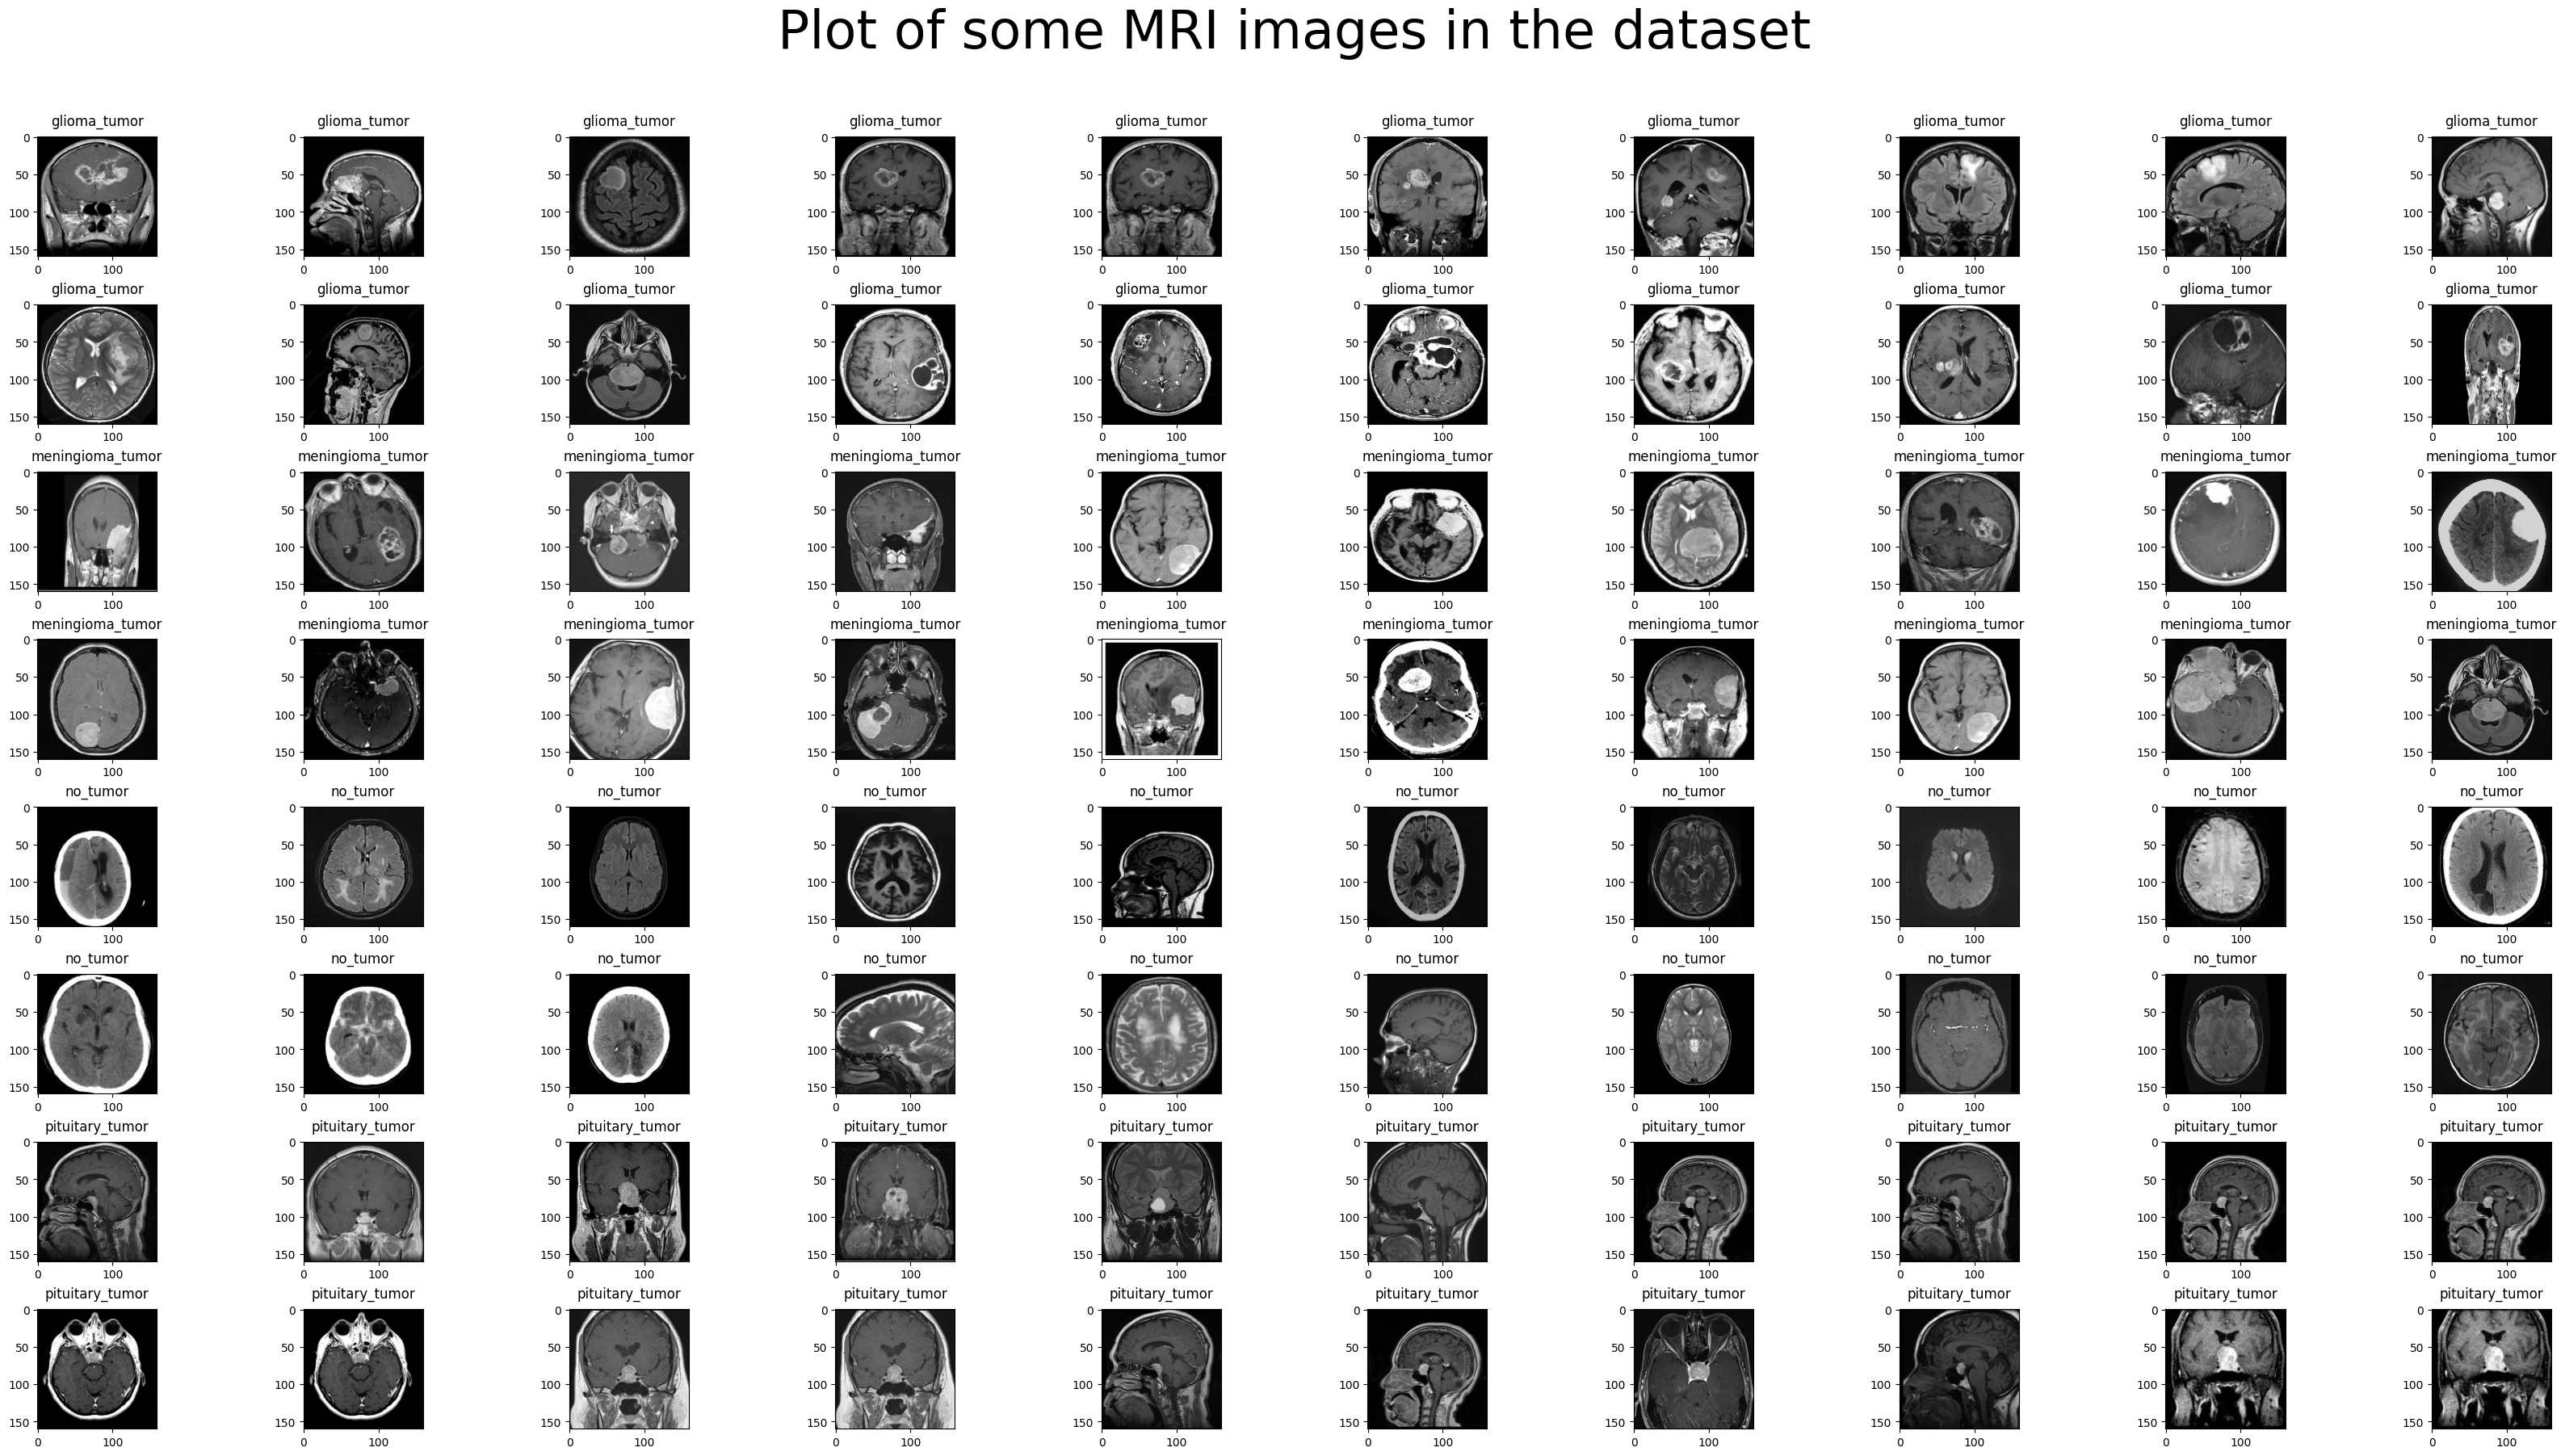

In [18]:
#here I plotted the images based on columns and z_max (defined by the user, 
#but it should be a multiple of the # of columns)
columns = 10
fig,axes=plt.subplots(int(len(images)*len(images[0])/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(images):
    #print(images_class)
    fig.suptitle('Plot of some MRI images in the dataset',fontsize=47)
    for j, image in enumerate(ind):
        #print(j,image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{classes[i]}',pad=10)
#image_plotting(X_test[:1])
#plt.savefig(os.path.join('plots/','Some_MRI_images_in_the_dataset_white.png'), dpi=300,facecolor='w')

## Working on Transfer Learning

In [28]:
base_model = keras.models.load_model('models/EfficientNetV2B0.keras')

# Freeze the base model
base_model.trainable = False

# Get the output tensor of the base model
x = base_model.output
x = keras.layers.Reshape((1, 1, -1))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(x)
x = tf.keras.layers.Dropout(rate=0.33)(x)
x = tf.keras.layers.Dense(4,activation='softmax')(x)

# Create the new model
outputs = keras.layers.Dense(1, name="custom_output")(x)
model = keras.Model(inputs=base_model.input, outputs=outputs)

# Compile and train the model
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) 
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping_cb, reduce_lr])

# Unfreeze the base model
base_model.trainable = True

# Recompile and continue training the model
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) 
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping_cb, reduce_lr])

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 55s 391ms/step - accuracy: 0.2893 - loss: 3.9097 - val_accuracy: 0.2837 - val_loss: 0.9028 - learning_rate: 0.0010
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 29s 339ms/step - accuracy: 0.3475 - loss: 0.7375 - val_accuracy: 0.5510 - val_loss: -0.4293 - learning_rate: 0.0010
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 31s 351ms/step - accuracy: 0.4471 - loss: -1.1498 - val_accuracy: 0.5490 - val_loss: -10.9633 - learning_rate: 0.0010
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 31s 351ms/step - accuracy: 0.4273 - loss: -6.1982 - val_accuracy: 0.2878 - val_loss: -10.7169 - learning_rate: 0.0010
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 32s 366ms/step - accuracy: 0.4372 - loss: -8.5795 - val_accuracy: 0.2878 - val_loss: -10.7573 - learning_rate: 0.0010
Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.3831 - loss: 0.4122 - val_accuracy: 0.2878 - val_loss: -1.6342 - learning_rate: 0.0010
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.3724 - l

## Save Model & Plot Performance

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - accuracy: 0.3025 - loss: -1.4627
Accuracy: 28.775510


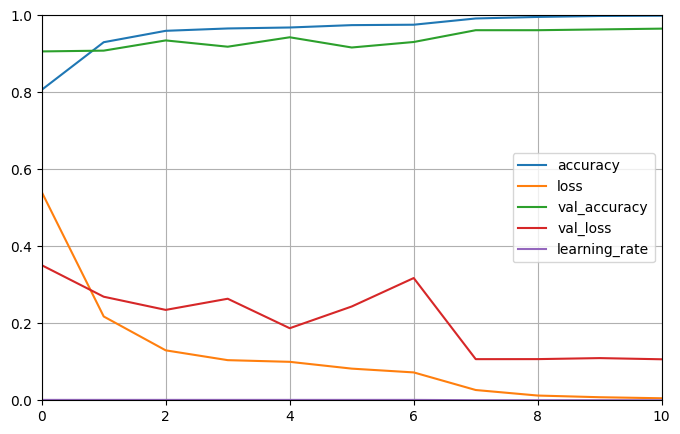

In [29]:
#save the model
model.save('models/Transfer.keras')
model.save_weights('models/Transfer.weights.h5')

#plot loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)

plt.gca().set_xlim(0,10)
plt.gca().set_ylim(0,1)
plt.savefig('plots/EfficientNetV2B0.png')
loss, accuracy = model.evaluate(X_test,y_test)

#print accuracy    
print('Accuracy: %f' % (accuracy*100))

In [30]:
model=keras.models.load_model('models/Transfer.keras')  
loss, accuracy = model.evaluate(X_test,y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 304ms/step - accuracy: 0.3025 - loss: -1.4627


## Accuracy and Loss

In [31]:
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 28.776 
 loss : -1.634


In [32]:

y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred) #predicted labels

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 614ms/step


In [33]:
pd.Series(pred_labels).value_counts()

glioma_tumor    490
Name: count, dtype: int64

## Confusion Matrix

Text(98.2222222222222, 0.5, 'Predicted class')

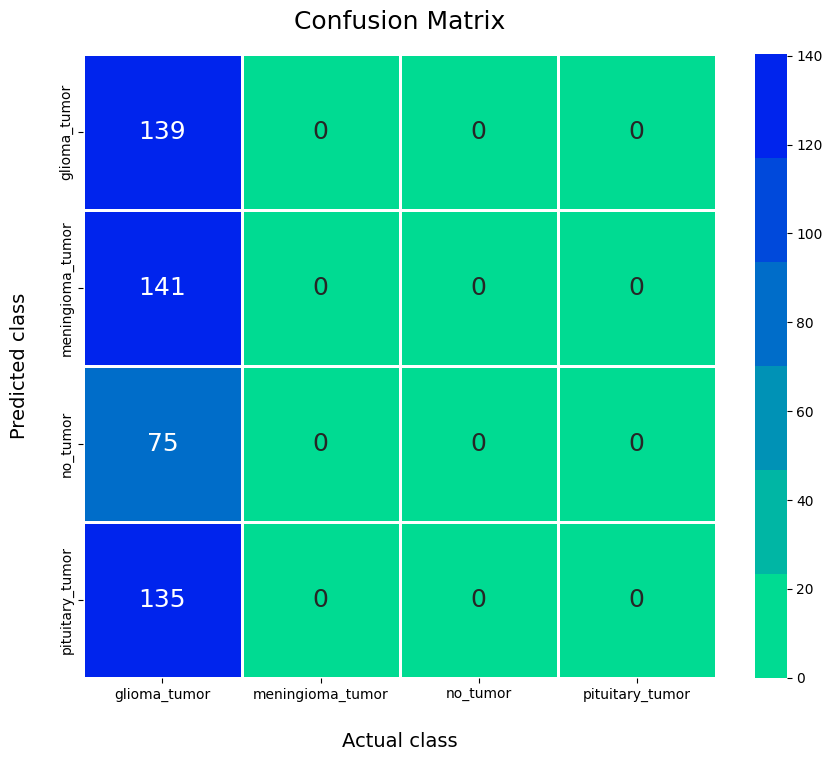

In [34]:
cm = confusion_matrix(y_test,pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r inverts the palette
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
 #annot_kws: settings about annotations
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)
#plt.savefig(os.path.join('plots/','EfficientNetB3_confusion_matrix.png'), dpi=300)

## Model Preformance Scores

In [35]:
print(classification_report(y_test,pred,target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.28      1.00      0.44       139
meningioma_tumor       0.00      0.00      0.00       141
        no_tumor       0.00      0.00      0.00        75
 pituitary_tumor       0.00      0.00      0.00       135

        accuracy                           0.28       490
       macro avg       0.07      0.25      0.11       490
    weighted avg       0.08      0.28      0.13       490



C:\Users\betsy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betsy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\betsy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

In [36]:
import matplotlib.image as mpimg
TEST_DIR='input/Testing'
#fetch images from the original validation dataset and resize them in order to plot the images.
images=[] 
n_classes=4
z_max=20
for i,filenames in enumerate(os.listdir(TEST_DIR)): 
    dir_fold=os.path.join(TEST_DIR, filenames)
    print(dir_fold)
    class_images=[]
    z=0
    for filename in os.listdir(dir_fold):
        if z < z_max:
            img_path = os.path.join(dir_fold, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img,(image_size,image_size))
            class_images.append(img)
            z+=1
        else:
            break
    images.append(class_images)
images=images[:20]

input/Testing\glioma_tumor
input/Testing\meningioma_tumor
input/Testing\no_tumor
input/Testing\pituitary_tumor


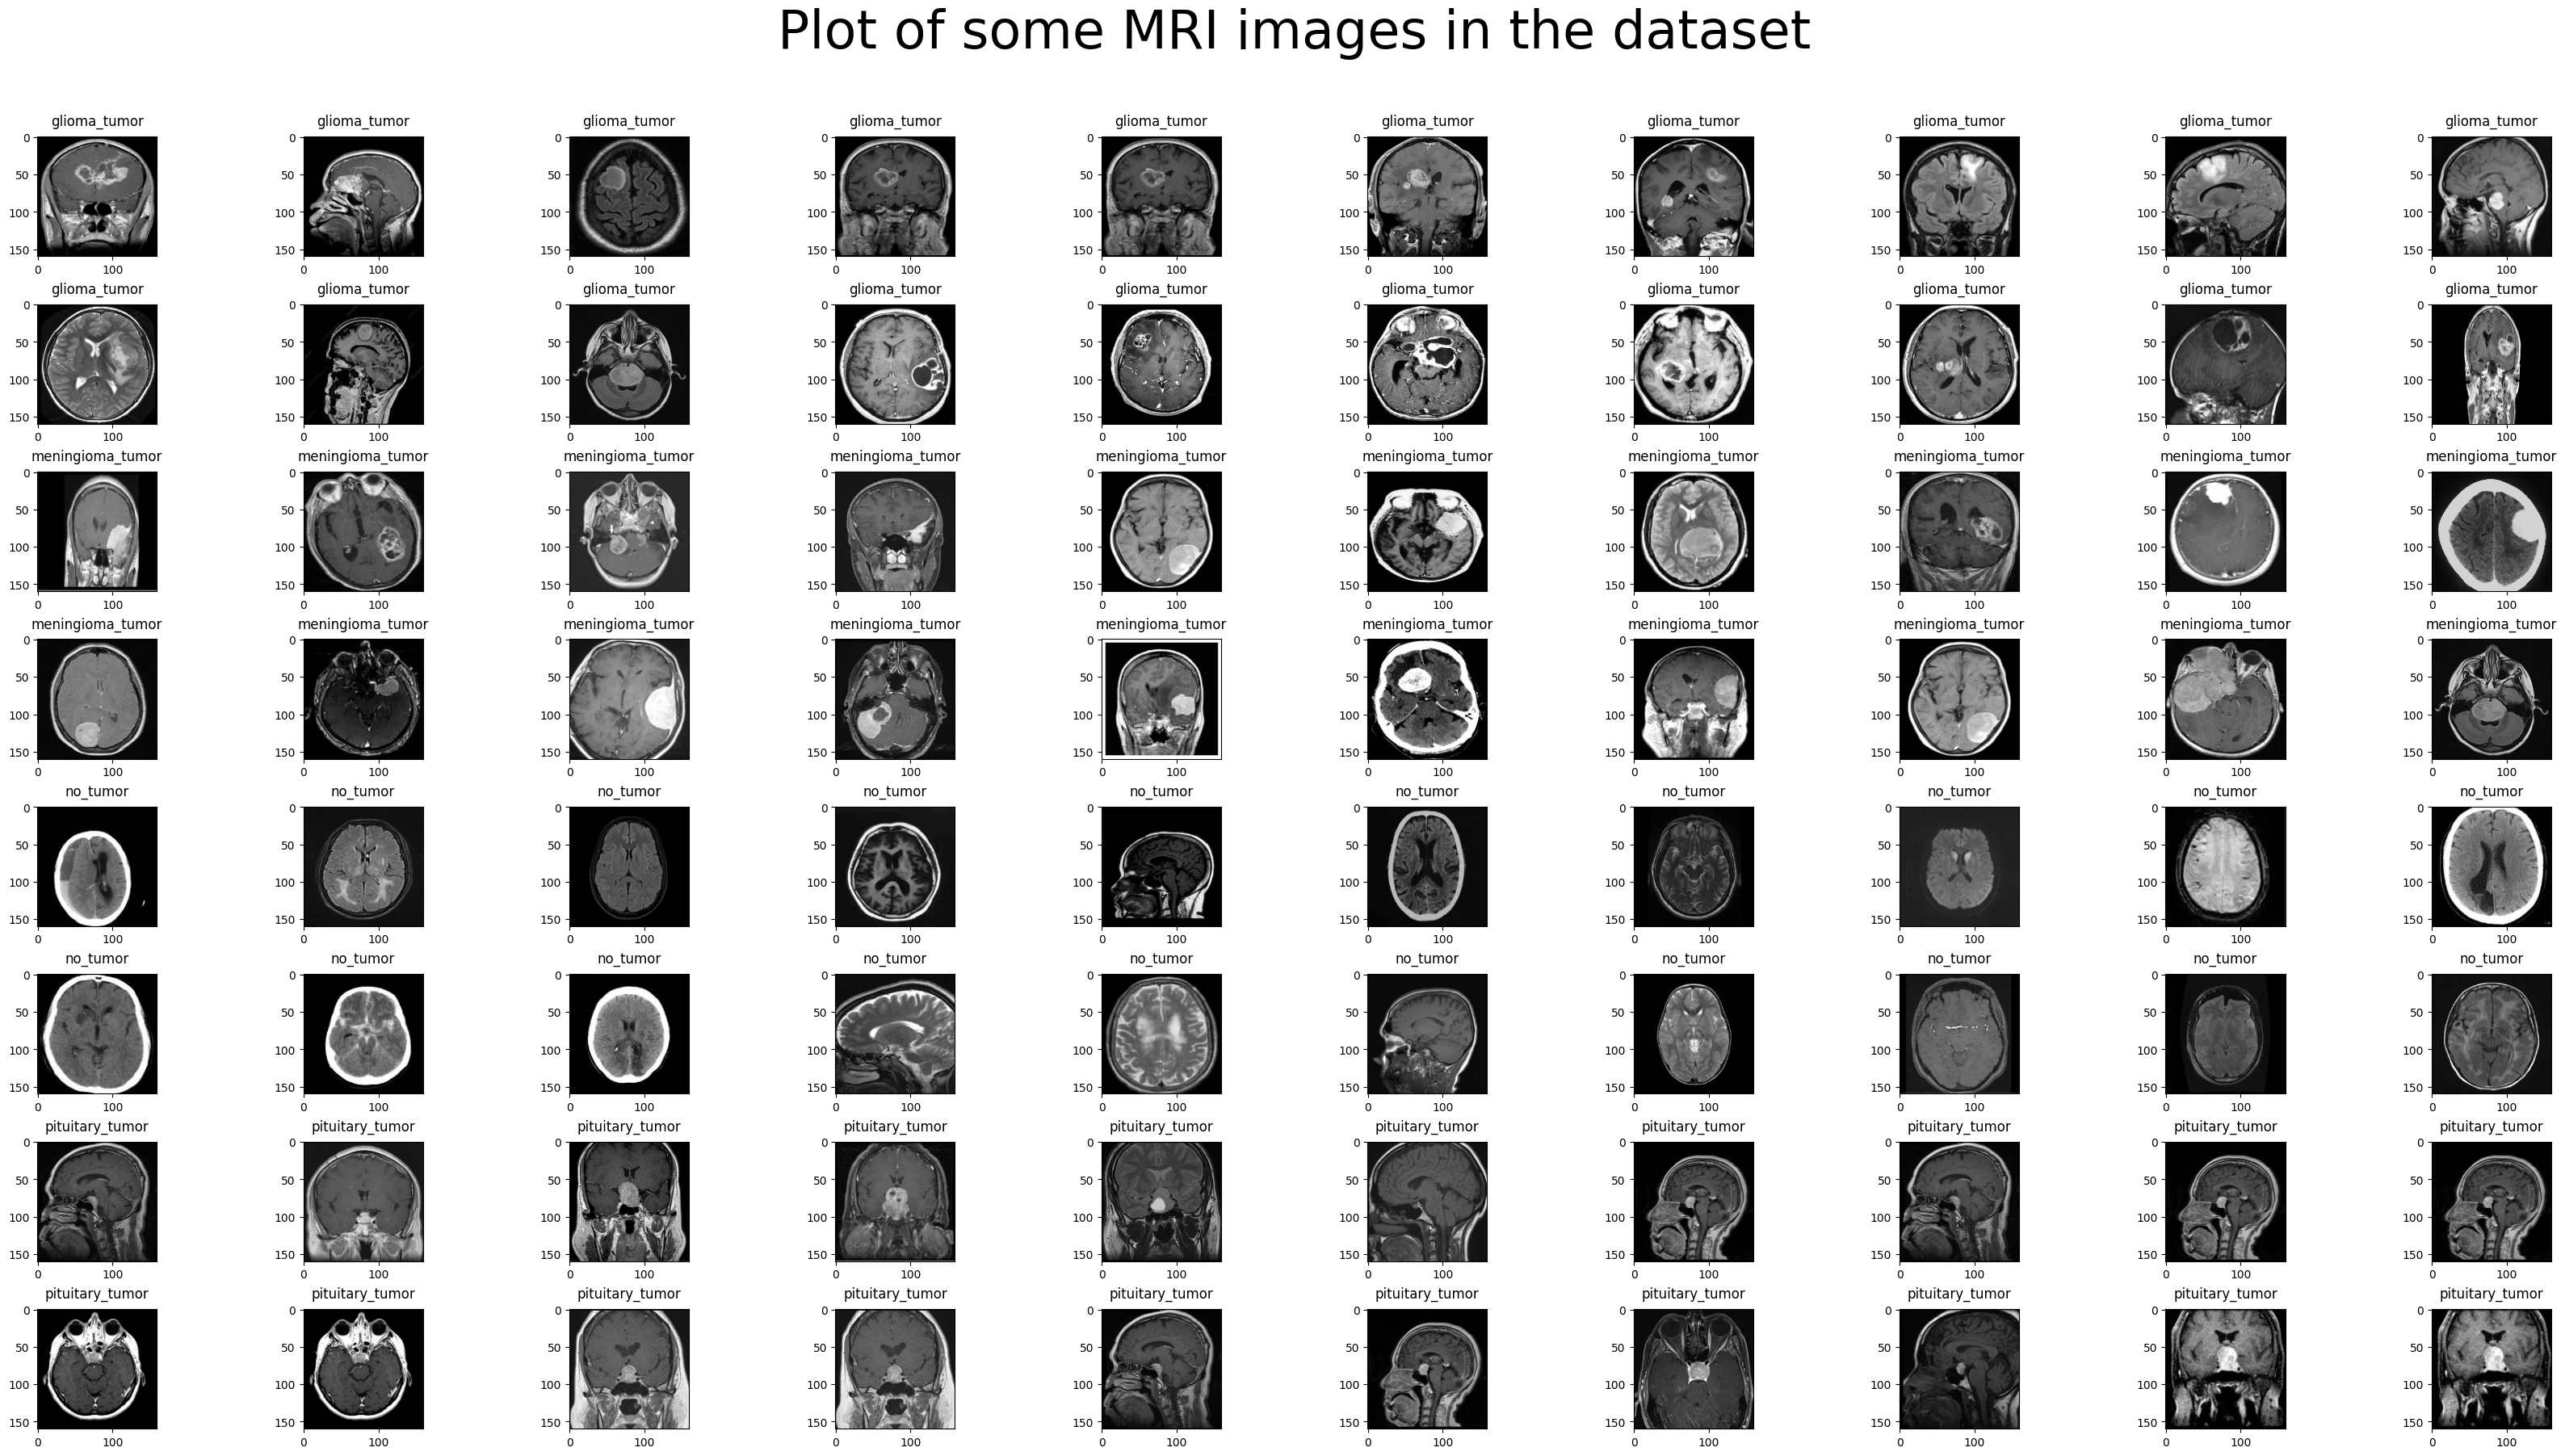

In [37]:
#here I plotted the images based on columns and z_max (defined by the user, 
#but it should be a multiple of the # of columns)
columns = 10
fig,axes=plt.subplots(int(len(images)*len(images[0])/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(images):
    #print(images_class)
    fig.suptitle('Plot of some MRI images in the dataset',fontsize=47)
    for j, image in enumerate(ind):
        #print(j,image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{classes[i]}',pad=10)
#image_plotting(X_test[:1])
#plt.savefig(os.path.join('plots/','Some_MRI_images_in_the_dataset_white.png'), dpi=300,facecolor='w')